# Projected Outcomes Extreme Case Sensitivity Analysis

This notebook contains the code for the sensitivty analysis of the projection model used to project outcomes under the 10x5 and 50x1 districting plans using demographic threshold inference model (see section 5 of the report).

The sensitivity analysis proceeds by altering the probabilities of the samplers. As opposed to many cases, this notebook tests the most extreme scenarios:

**50x1 Ensemble**:
1. (1, 0, 0, 0): each ward elects a member of the most populous race
2. (1/2, 1/2, 0, 0): each ward is equally likely to elect a member of either of the two most populous races
3. (1/3, 1/3, 1/3, 0): each ward is equally likely to elect a member of either of the three most populous races

**10x5 Ensemble**:
1. elect all five members of the most populous race
2. elect 3 members of the most populous race and 2 members of the second most populous race
3. elect 2 members of the most populous race, 2 members of the second most populous race, and 1 member of the third most populous race

**10x3 Ensemble**:
1. elect all three members of the most populous race
2. elect 2 members of the most populous race and 1 member of the second most populous race
3. elect 1 member of the most populous race, 1 member of the second most populous race, and 1 member of the third most populous race

In [1]:
import pandas
import numpy
from collections import namedtuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import itertools

## Projection model code

In [2]:
class ElectionSampler:
    cases = None
    threshold = None
    
    def decide_case(self, groups: pandas.Series):
        number_over_threshold = (groups > self.threshold).sum()
        return self.cases[number_over_threshold]

    def sample(self, groups: pandas.Series):
        """
        :param pandas.Series groups: a single row of a DataFrame with the percentages
            of each racial group in a ward.
        """
        outcomes, probabilities = self.decide_case(groups)
        outcome_index = numpy.random.choice(a=numpy.arange(len(outcomes)), p=probabilities)
        outcome = outcomes[outcome_index]
        groups_from_highest_to_lowest = groups.sort_values(ascending=False).keys()
        full_outcome = itertools.chain(
            outcome,
            itertools.repeat(0, len(groups_from_highest_to_lowest) - len(outcome))
        )
        return pandas.Series(full_outcome, index=groups_from_highest_to_lowest)

class ElectionSamplerWithMajority(ElectionSampler):
    def decide_case(self, groups: pandas.Series):
        number_over_threshold = (groups > self.threshold).sum()
        any_majority = (groups > 0.5).any()
        if any_majority and number_over_threshold in self.cases["majority"]:
            return self.cases["majority"][number_over_threshold]
        else:
            return self.cases["plurality"][number_over_threshold]

class ExtremeSampler(ElectionSampler):
    def decide_case(self, groups):
        return self.cases[1]

In [3]:
class Case:
    def __init__(self, outcomes, probabilities):
        assert len(outcomes) == len(probabilities)
        assert all(isinstance(x, tuple) for x in outcomes)
        self.outcomes = outcomes
        self.probabilities = numpy.reshape(numpy.asarray(probabilities), len(probabilities))
    
    def __iter__(self):
        return iter((self.outcomes, self.probabilities))

## Sampling classes
Each of the sampling classes below has been altered for the sensitivity analysis, with the first in each type being the control (the sampler used for the paper).

In [4]:
# Control
class FiftyByOneSampler_1(ElectionSamplerWithMajority):
    cases = {
        "majority": {
            2: Case(((1,), (0,1)), (0.9, 0.1)),
            3: Case(((1,), (0,1,), (0,0,1)), (0.8, 0.18, 0.02))
        },
        "plurality": {
            1: Case(outcomes=((1,), (0,1)), probabilities=(1, 0)),
            2: Case(((1,), (0,1)), (0.6, 0.4)),
            3: Case(((1,), (0,1), (0,0,1)),(0.45, 0.3, 0.25))
        }
    }
    threshold = 0.25
    change = "No change"
    
# Extreme case changes
class FiftyByOneSampler_2(ExtremeSampler):
    cases = {
        1: Case(((1,),), (1.,)),
    }
    threshold = 0.25
    change = "50x1: Extreme Case 1"

class FiftyByOneSampler_3(ExtremeSampler):
    cases = {
        1: Case(((1,), (0,1)), (0.5, 0.5)),
    }
    threshold = 0.25
    change = "50x1: Extreme Case 2"

class FiftyByOneSampler_4(ExtremeSampler):
    cases = {
        1: Case(((1,), (0,1), (0,0,1)), (1/3,1/3,1/3)),
    }
    threshold = 0.25
    change = "50x1: Extreme Case 3"

fiftyxone = [FiftyByOneSampler_1(),
             FiftyByOneSampler_2(),
             FiftyByOneSampler_3(),
             FiftyByOneSampler_4(),
            ]

In [5]:
# Control
class TenByFiveSampler_1(ElectionSampler):
    cases = {
        1: Case(outcomes=((5,), (4,1)), probabilities=(0.5, 0.5)),
        2: Case(((4, 1), (3, 2), (2, 3), (2, 2, 1), (3, 1, 1)), (0.25, 0.55, 0.1, 0.05, 0.05)),
        3: Case(((3, 1, 1), (3, 2), (2, 3), (2, 2, 1), (2, 1, 2)), (0.25, 0.25, 0.15, 0.2, 0.15)),
        4: Case(((3, 1, 1), (3, 2), (2, 3), (2, 2, 1), (2, 1, 2)), (0.2, 0.2, 0.2, 0.2, 0.2))
    }
    threshold = 1/6
    change = "No change."

# Extreme case changes
class TenByFiveSampler_2(ExtremeSampler):
    cases = {
        1: Case(((5,),), (1.,)),
    }
    threshold = 1/6
    change = "10x5: Extreme Case 1"

class TenByFiveSampler_3(ExtremeSampler):
    cases = {
        1: Case(((3, 2),), (1.,)),
    }
    threshold = 1/6
    change = "10x5: Extreme Case 2"

class TenByFiveSampler_4(ExtremeSampler):
    cases = {
        1: Case(((2, 2, 1),), (1.,)),
    }
    threshold = 1/6
    change = "10x5: Extreme Case 3"

tenxfive = [TenByFiveSampler_1(),
            TenByFiveSampler_2(),
            TenByFiveSampler_3(),
            TenByFiveSampler_4(),
           ]

In [6]:
# Control
class TenByThreeSampler_1(ElectionSamplerWithMajority):
    cases = {
        "majority": {
            1: Case(outcomes=((3,), (2,1)), probabilities=(0.9, 0.1)),
            2: Case(((3,), (2,1)), (0.2, 0.8)),
            3: Case(((3,), (2,1), (1,2), (1,1,1)), (0.1, 0.5, 0.3, 0.1)),
            
        },
        "plurality": {
            1: Case(((3,), (2,1)), (0.5, 0.5)),
            2: Case(((3,), (2,1), (1,2), (1,1,1)), (0.1, 0.5, 0.3, 0.1)),
            3: Case(((3,), (2,1), (1,2), (1,1,1)), (0.05, 0.15, 0.1, 0.7))
        }
    }
    threshold = 0.25
    change = "No change."

# Extreme case changes
class TenByThreeSampler_2(ExtremeSampler):
    cases = {
        1: Case(((3,),), (1.,)),
    }
    threshold = 1/6
    change = "10x3: Extreme Case 1"

class TenByThreeSampler_3(ExtremeSampler):
    cases = {
        1: Case(((2, 1),), (1.,)),
    }
    threshold = 1/6
    change = "10x3: Extreme Case 2"

class TenByThreeSampler_4(ExtremeSampler):
    cases = {
        1: Case(((1, 1, 1),), (1.,)),
    }
    threshold = 1/6
    change = "10x3: Extreme Case 3"

tenxthree = [TenByThreeSampler_1(),
             TenByThreeSampler_2(),
             TenByThreeSampler_3(),
             TenByThreeSampler_4(),
            ]

In [7]:
def load_data(filename):
    df = pandas.read_csv(filename)
    data = pandas.DataFrame(
        {
            "step": df["step"],
            "ward": df["ward"],
            "White": df["NH_WHITE"] / df["TOTPOP"],
            "Black": df["NH_BLACK"] / df["TOTPOP"],
            "Hispanic": df["HISP"] / df["TOTPOP"],
            "Asian": df["NH_ASIAN"] / df["TOTPOP"],
        }
    )
    return data

## Generating the projections

In [8]:
def random_sample(data, size, sampler):
    # Print the sample specification changes
    print()
    print("----------------------------------------------------------")
    print(sampler.change)
    print("----------------------------------------------------------")
    
    all_plans = {step: data.loc[indices] for step, indices in data.groupby("step").groups.items()}
    groups = ["White", "Black", "Hispanic", "Asian"]
    plan_indices = data["step"].unique()
    
    for plan_index in tqdm(numpy.random.choice(plan_indices, size=size)):
        wards = all_plans[plan_index]
        yield wards[groups].apply(sampler.sample, axis=1).sum()

In [9]:
groups = ["Asian", "Black", "Hispanic", "White"]

In [10]:
# Load in the data
prec50 = load_data("../ensembles/prec50/results.csv")
prec10 = load_data("../ensembles/prec10/results.csv")
ca10 = load_data("../ensembles/ca10/results.csv")

## Generate projections for every sample specification

In [11]:
num_samples = 10_000
fiftyxone_results = []
tenxfive_results = []
tenxthree_results = []


-------------------------------
FiftyByOne sensitivity analysis
-------------------------------

----------------------------------------------------------
No change
----------------------------------------------------------


100%|██████████| 10000/10000 [1:02:41<00:00, 12.26it/s]


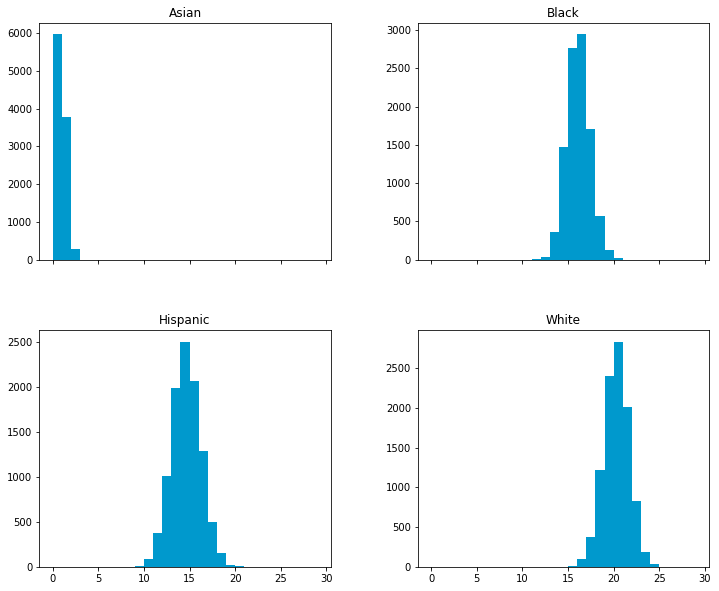


Results:

Asian        0.4305
Black       15.6343
Hispanic    14.1390
White       19.7962
dtype: float64

----------------------------------------------------------
50x1: Extreme Case 1
----------------------------------------------------------


100%|██████████| 10000/10000 [07:54<00:00, 21.18it/s]


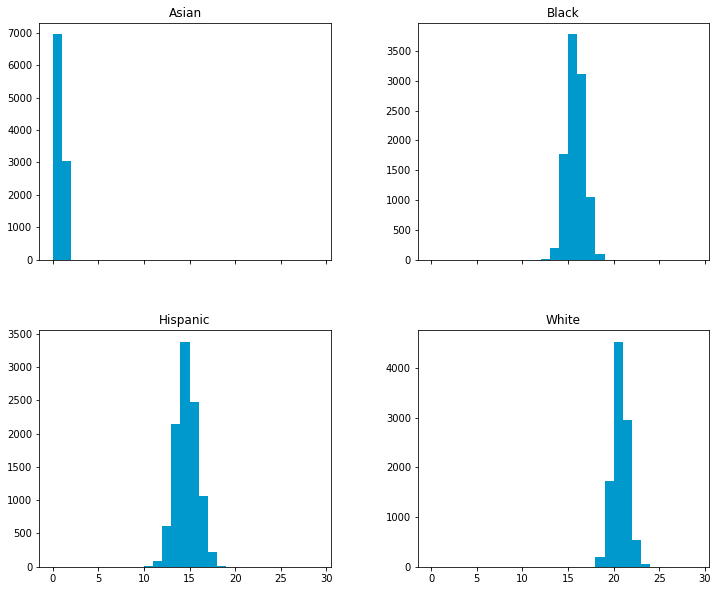


Results:

Asian        0.3051
Black       15.3282
Hispanic    14.1620
White       20.2047
dtype: float64

----------------------------------------------------------
50x1: Extreme Case 2
----------------------------------------------------------


100%|██████████| 10000/10000 [07:36<00:00, 21.61it/s]


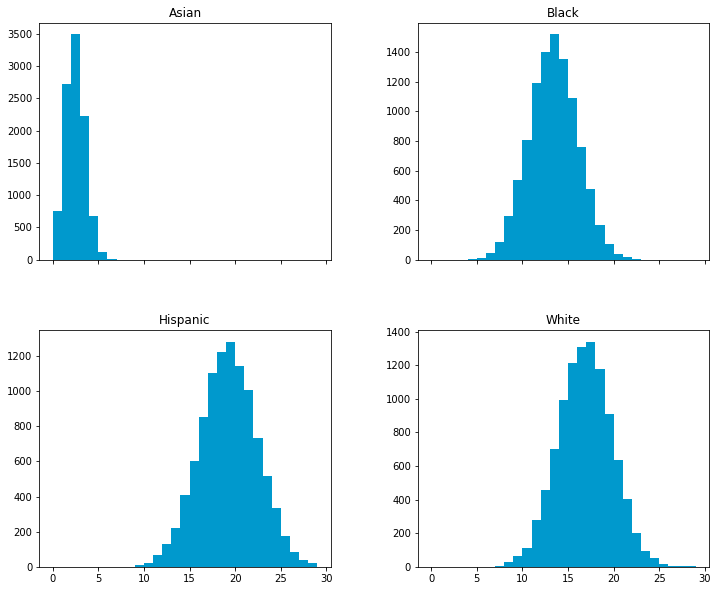


Results:

Asian        1.9734
Black       12.8934
Hispanic    18.7768
White       16.3564
dtype: float64

----------------------------------------------------------
50x1: Extreme Case 3
----------------------------------------------------------


100%|██████████| 10000/10000 [07:38<00:00, 21.75it/s]


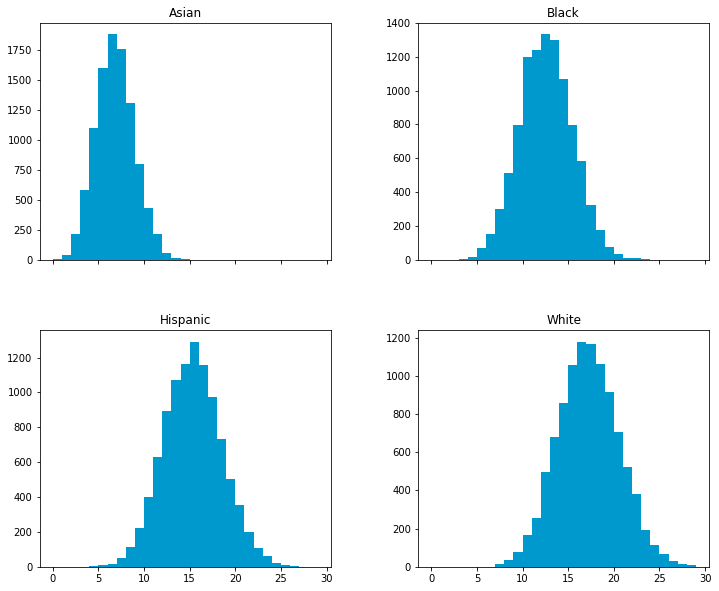


Results:

Asian        6.3416
Black       12.0750
Hispanic    14.8656
White       16.7178
dtype: float64


In [12]:
# FiftyByOne
print()
print("-------------------------------")
print("FiftyByOne sensitivity analysis")
print("-------------------------------")
data = prec50
for sampler in fiftyxone:
    # Sample
    outcomes = pandas.DataFrame.from_records(random_sample(data, num_samples, sampler))
    outcomes.groupby(groups).size()
    # Plot the results
    outcomes[groups].hist(sharex=True, grid=False, figsize=(12,10), color="#0099cd", bins=list(range(30)))
    plt.show()
    print()
    # Compute statistics for the projected outcomes
    results = outcomes.mean()
    fiftyxone_results.append(results)
    print("Results:")
    print()
    print(results)

TenByFive sensitivity analysis

----------------------------------------------------------
No change.
----------------------------------------------------------


100%|██████████| 10000/10000 [02:31<00:00, 66.06it/s]


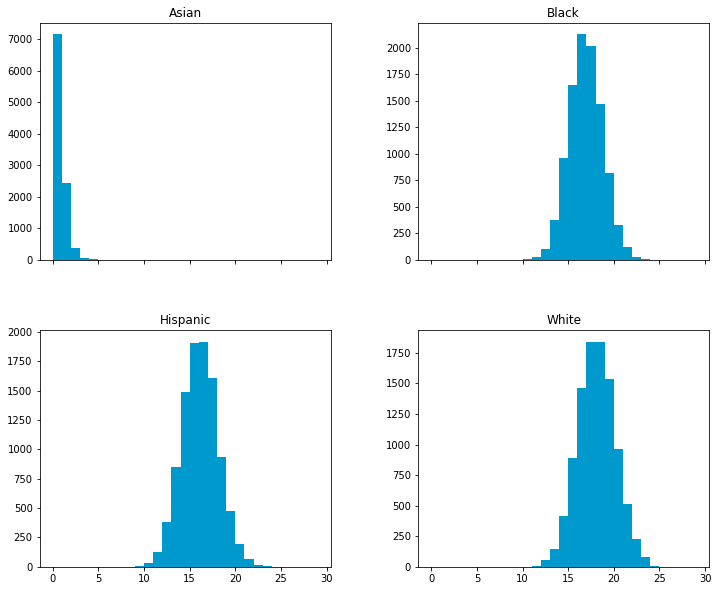


Results:

Asian        0.3322
Black       16.4239
Hispanic    15.6264
White       17.6175
dtype: float64

----------------------------------------------------------
10x5: Extreme Case 1
----------------------------------------------------------


100%|██████████| 10000/10000 [01:55<00:00, 86.70it/s]


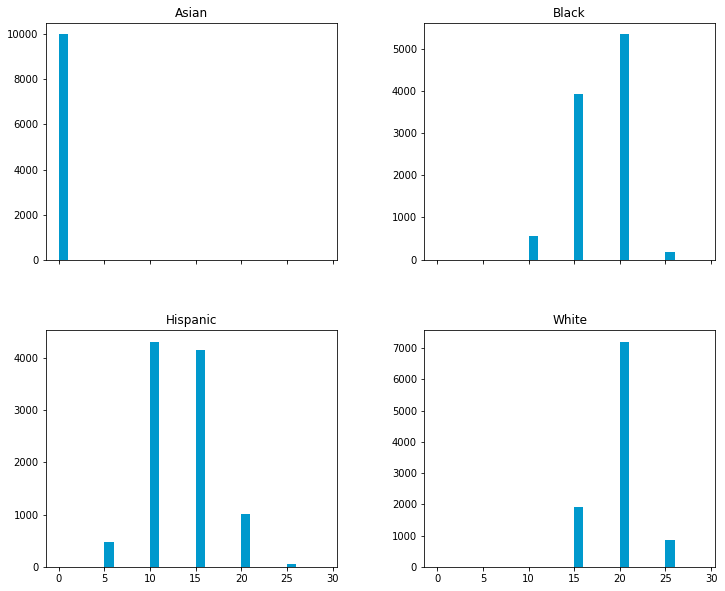


Results:

Asian        0.0000
Black       17.5765
Hispanic    12.9510
White       19.4725
dtype: float64

----------------------------------------------------------
10x5: Extreme Case 2
----------------------------------------------------------


100%|██████████| 10000/10000 [01:56<00:00, 85.66it/s]


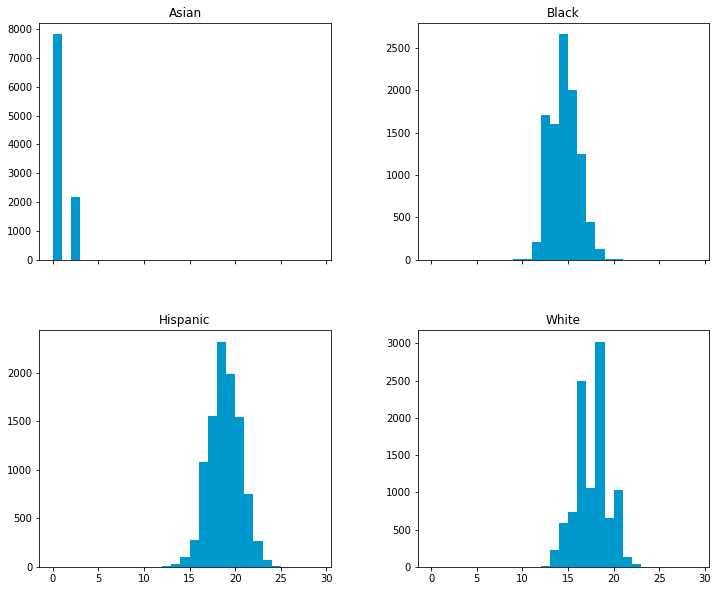


Results:

Asian        0.4370
Black       14.0640
Hispanic    18.3657
White       17.1333
dtype: float64

----------------------------------------------------------
10x5: Extreme Case 3
----------------------------------------------------------


100%|██████████| 10000/10000 [01:54<00:00, 87.11it/s]


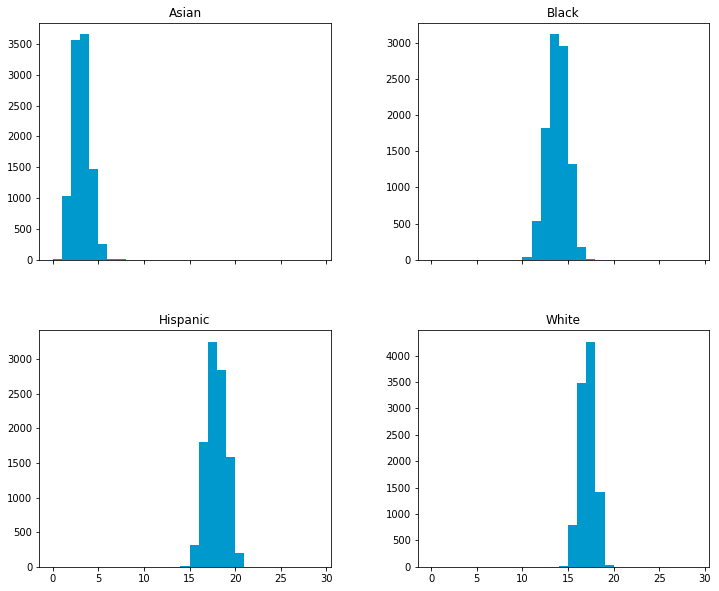


Results:

Asian        2.6362
Black       13.3129
Hispanic    17.4135
White       16.6374
dtype: float64


In [13]:
# TenByFive
print("TenByFive sensitivity analysis")
data = prec10
for sampler in tenxfive:
    # Sample
    outcomes = pandas.DataFrame.from_records(random_sample(data, num_samples, sampler))
    outcomes.groupby(groups).size()
    # Plot the results
    outcomes[groups].hist(sharex=True, grid=False, figsize=(12,10), color="#0099cd", bins=list(range(30)))
    plt.show()
    print()
    # Compute statistics for the projected outcomes
    results = outcomes.mean()
    tenxfive_results.append(results)
    print("Results:")
    print()
    print(results)

TenByThree sensitivity analysis

----------------------------------------------------------
No change.
----------------------------------------------------------


100%|██████████| 10000/10000 [03:02<00:00, 54.88it/s]


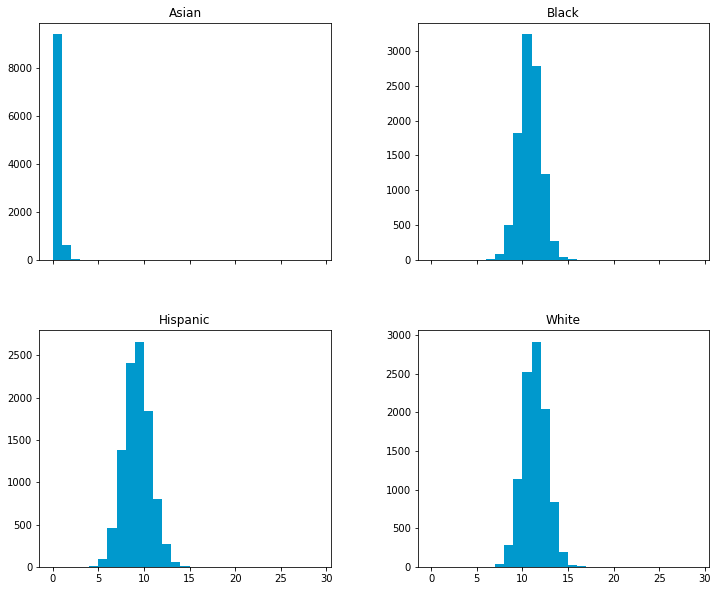


Results:

Asian        0.0621
Black       10.3151
Hispanic     8.7591
White       10.8637
dtype: float64

----------------------------------------------------------
10x3: Extreme Case 1
----------------------------------------------------------


100%|██████████| 10000/10000 [01:55<00:00, 86.28it/s]


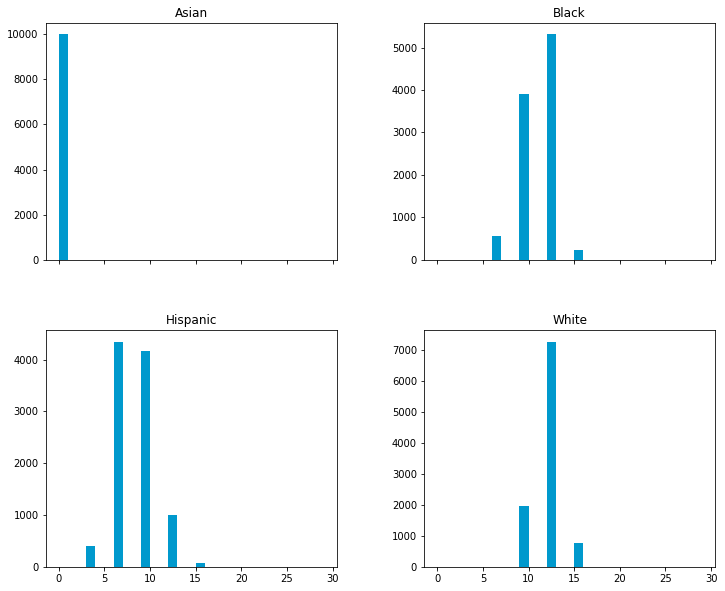


Results:

Asian        0.0000
Black       10.5648
Hispanic     7.7925
White       11.6427
dtype: float64

----------------------------------------------------------
10x3: Extreme Case 2
----------------------------------------------------------


100%|██████████| 10000/10000 [01:55<00:00, 86.62it/s]


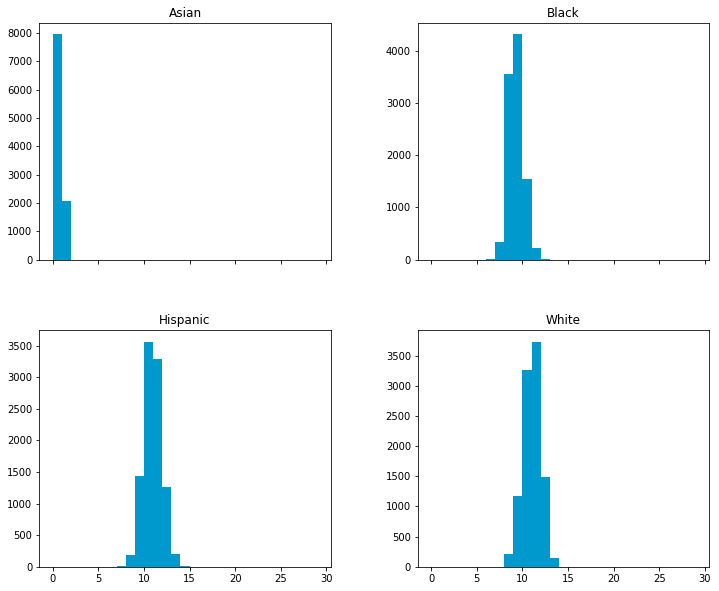


Results:

Asian        0.2051
Black        8.7781
Hispanic    10.4636
White       10.5532
dtype: float64

----------------------------------------------------------
10x3: Extreme Case 3
----------------------------------------------------------


100%|██████████| 10000/10000 [01:54<00:00, 87.50it/s]


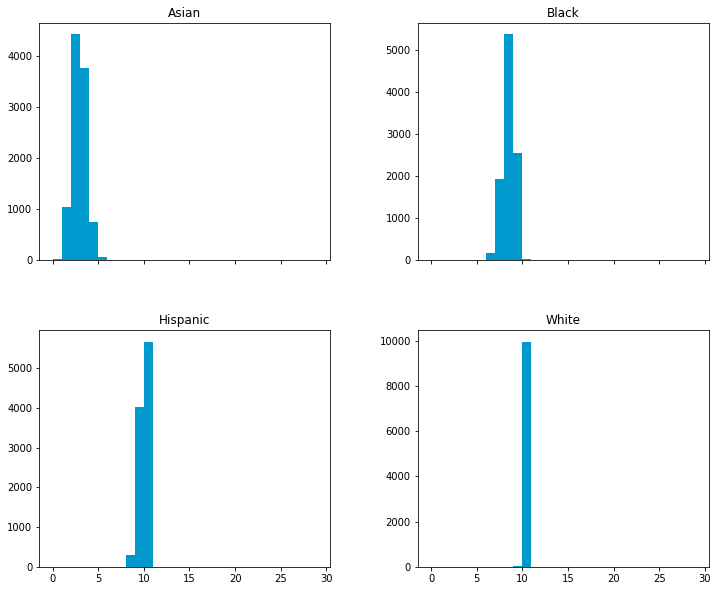


Results:

Asian       2.4348
Black       8.0325
Hispanic    9.5366
White       9.9961
dtype: float64


In [14]:
# TenByThree
print("TenByThree sensitivity analysis")
data = prec10
for sampler in tenxthree:
    # Sample
    outcomes = pandas.DataFrame.from_records(random_sample(data, num_samples, sampler))
    outcomes.groupby(groups).size()
    # Plot the results
    outcomes[groups].hist(sharex=True, grid=False, figsize=(12,10), color="#0099cd", bins=list(range(30)))
    plt.show()
    print()
    # Compute statistics for the projected outcomes
    results = outcomes.mean()
    tenxthree_results.append(results)
    print("Results:")
    print()
    print(results)

## Store the results

In [15]:
# Convert the list of series into dataframes for storage 
# and analysis, then save to CSVs
# FiftyByOne
fiftyxone_results = [df.to_frame().transpose() for df in fiftyxone_results]
df = pandas.concat(fiftyxone_results, axis=0)
df = df.reset_index().drop(['index'], axis=1)
df.index += 1
df.to_csv("./sensitivity_analysis/extreme/fifty_by_one.csv", index=False)

In [16]:
# TenByFive
tenxfive_results = [df.to_frame().transpose() for df in tenxfive_results]
df = pandas.concat(tenxfive_results, axis=0)
df = df.reset_index().drop(['index'], axis=1)
df.index += 1
df.to_csv("./sensitivity_analysis/extreme/ten_by_five.csv", index=False)

In [17]:
# TenByThree
tenxthree_results = [df.to_frame().transpose() for df in tenxthree_results]
df = pandas.concat(tenxthree_results, axis=0)
df = df.reset_index().drop(['index'], axis=1)
df.index += 1
df.to_csv("./sensitivity_analysis/extreme/ten_by_three.csv", index=False)

## Print The Scenarios

In [18]:
for x in fiftyxone:
    print(x.change)

No change
50x1: Extreme Case 1
50x1: Extreme Case 2
50x1: Extreme Case 3


In [19]:
for x in tenxfive:
    print(x.change)

No change.
10x5: Extreme Case 1
10x5: Extreme Case 2
10x5: Extreme Case 3


In [20]:
for x in tenxthree:
    print(x.change)

No change.
10x3: Extreme Case 1
10x3: Extreme Case 2
10x3: Extreme Case 3
